In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据

In [2]:
path = '/Users/apple/Desktop/data/basicclick_data/'
    
train = pd.read_csv(path+'train_all.csv')
test = pd.read_csv(path+'test_all.csv')

In [3]:
train.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2'],
      dtype='object')

In [4]:
len(train.columns)

33

In [5]:
test.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2'],
      dtype='object')

In [6]:
train.head(5)

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,is_trade,time,day,hour,minute,maphour,mapmin,item_category_0,item_category_1,item_category_2
0,5.089880e+18,2769,5982,2,6,11,10,17,60637,0,...,0,2018-09-02 20:31:59,2,20,31,4,2,0,7,0
1,2.163600e+18,16242,4705,147,6,9,10,16,33155,0,...,0,2018-09-05 13:13:58,5,13,13,3,14,0,21,0
2,8.229730e+18,7731,5385,80,4,12,12,13,38351,0,...,0,2018-09-01 21:38:48,1,21,38,4,9,0,9,0
3,8.978460e+18,68,3543,128,9,4,5,11,91026,0,...,0,2018-09-02 22:58:54,2,22,58,4,14,0,7,0
4,3.831630e+18,556,6156,103,5,11,9,14,55740,0,...,0,2018-09-05 06:43:40,5,6,43,2,14,0,14,0


In [7]:
train.dtypes

instance_id                  float64
item_id                        int64
item_brand_id                  int64
item_city_id                   int64
item_price_level               int64
item_sales_level               int64
item_collected_level           int64
item_pv_level                  int64
user_id                        int64
user_gender_id                 int64
user_age_level                 int64
user_occupation_id             int64
user_star_level                int64
context_id                     int64
context_timestamp              int64
context_page_id                int64
shop_id                        int64
shop_review_num_level          int64
shop_review_positive_rate    float64
shop_star_level                int64
shop_score_service           float64
shop_score_delivery          float64
shop_score_description       float64
is_trade                       int64
time                          object
day                            int64
hour                           int64
m

# 合并数据

In [8]:
data = train.append(test, ignore_index=True)

/var/folders/hv/0r6f95ls1ss09znhzxqsj0nr0000gn/T/ipykernel_4888/447752923.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(test, ignore_index=True)


In [9]:
data.shape

(99085, 33)

# 移除['instance_id', 'day']特征

In [10]:
def pre_process(data):

    cols = data.columns.tolist()
    keys = ['instance_id', 'day']
    for k in keys:
        cols.remove(k)

    return data, cols

In [11]:
data, cols = pre_process(data)

In [12]:
data.shape

(99085, 33)

In [13]:
cols

['item_id',
 'item_brand_id',
 'item_city_id',
 'item_price_level',
 'item_sales_level',
 'item_collected_level',
 'item_pv_level',
 'user_id',
 'user_gender_id',
 'user_age_level',
 'user_occupation_id',
 'user_star_level',
 'context_id',
 'context_timestamp',
 'context_page_id',
 'shop_id',
 'shop_review_num_level',
 'shop_review_positive_rate',
 'shop_star_level',
 'shop_score_service',
 'shop_score_delivery',
 'shop_score_description',
 'is_trade',
 'time',
 'hour',
 'minute',
 'maphour',
 'mapmin',
 'item_category_0',
 'item_category_1',
 'item_category_2']

# 新特征：点击首次、末次

## 点击特征：1、2、3:第一次点击，中间点击，最后一次点击

In [14]:
# 按照'user_id', 'context_timestamp'排序
data.sort_values(['user_id', 'context_timestamp'], inplace=True)

### 某用户某天

In [15]:
subset = ['user_id', 'day']
data['click_user_lab'] = 1
# 标记某用户某天第一次点击，中间点击，最后一次点击(onehot)
pos = data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_lab'] = 1
pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_lab'] = 2
pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_lab'] = 3
del pos
gc.collect()

0

### 某用户某天某item

In [16]:
subset = ['item_id', 'user_id', 'day']
data['click_user_item_lab'] = 1
pos = data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_item_lab'] = 1
pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_item_lab'] = 2
pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_item_lab'] = 3
del pos
gc.collect()

0

### 某用户某天某品牌

In [17]:
subset = ['item_brand_id','user_id', 'day']
data['click_user_brand_lab'] = 1
pos = data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_brand_lab'] = 1
pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_brand_lab'] = 2
pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_brand_lab'] = 3
del pos
gc.collect()

0

In [18]:
data['click_user_brand_lab'].value_counts()

1    98811
2      137
3      137
Name: click_user_brand_lab, dtype: int64

### 某用户某天某商店

In [19]:
subset = ['shop_id','user_id', 'day']
data['click_user_shop_lab'] = 1
pos = data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_shop_lab'] = 1
pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_shop_lab'] = 2
pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_shop_lab'] = 3
del pos
gc.collect()

0

In [20]:
data['click_user_shop_lab'].value_counts()

1    98921
2       82
3       82
Name: click_user_shop_lab, dtype: int64

### 某用户某天某城市

In [21]:
subset = ['item_city_id','user_id', 'day']
data['click_user_city_lab'] = 1
pos = data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_city_lab'] = 1
pos = (~data.duplicated(subset=subset, keep='first')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_city_lab'] = 2
pos = (~data.duplicated(subset=subset, keep='last')) & data.duplicated(subset=subset, keep=False)
data.loc[pos, 'click_user_city_lab'] = 3
del pos
gc.collect()

0

## 点击特征总结：新增5个特征

In [22]:
# click_user_lab, click_user_item_lab, click_user_brand_lab,click_user_shop_lab,click_user_city_lab
data.shape

(99085, 38)

In [23]:
data.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2',
       'click_user_lab', 'click_user_item_lab', 'click_user_brand_lab',
       'click_user_shop_lab', 'click_user_city_lab'],
      dtype='object')

# 新特征：点击时间差

## 首次点击与当前点击的时间差：用户角度

In [24]:
data.sort_values(['user_id', 'context_timestamp'], inplace=True)

#user_id
subset = ['user_id', 'day']
# 提取三列的数据
# temp = data.loc[:,['context_timestamp', 'user_id', 'day']]
# 用户首次点击
temp = data.loc[:,['context_timestamp', 'user_id', 'day']].drop_duplicates(subset=subset, keep='first')
temp.rename(columns={'context_timestamp': 'u_day_diffTime_first'}, inplace=True)

In [25]:
data = pd.merge(data, temp, how='left', on=subset)

In [26]:
data.shape # 多一列u_day_diffTime_first，首次点击的时间

(99085, 39)

In [27]:
# 首次点击与当前点击的时间差
data['u_day_diffTime_first'] = data['context_timestamp'] - data['u_day_diffTime_first']
del temp
gc.collect()

0

## 最后次点击与当前点击的时间差

In [28]:
temp = data.loc[:,['context_timestamp', 'user_id', 'day']].drop_duplicates(subset=subset, keep='last')
temp.rename(columns={'context_timestamp': 'u_day_diffTime_last'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['u_day_diffTime_last'] = data['u_day_diffTime_last'] - data['context_timestamp']
del temp
gc.collect()

0

In [29]:
# 没有发生重复点击的，只点击过一次的，时间差均设为-1
data.loc[~data.duplicated(subset=subset, keep=False), ['u_day_diffTime_first', 'u_day_diffTime_last']] = -1

## 点击时间差：商品角度
商品第一次被点击，最后一次被点击

In [30]:
subset = ['item_id', 'day']
temp = data.loc[:,['context_timestamp', 'item_id', 'day']].drop_duplicates(subset=subset, keep='first')
temp.rename(columns={'context_timestamp': 'i_day_diffTime_first'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['i_day_diffTime_first'] = data['context_timestamp'] - data['i_day_diffTime_first']
del temp
gc.collect()
temp = data.loc[:,['context_timestamp', 'item_id', 'day']].drop_duplicates(subset=subset, keep='last')
temp.rename(columns={'context_timestamp': 'i_day_diffTime_last'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['i_day_diffTime_last'] = data['i_day_diffTime_last'] - data['context_timestamp']
del temp
gc.collect()
data.loc[~data.duplicated(subset=subset, keep=False), ['i_day_diffTime_first', 'i_day_diffTime_last']] = -1

## 点击时间差：某用户某品牌

In [31]:
#item_brand_id, user_id
subset = ['item_brand_id', 'user_id', 'day']
temp = data.loc[:,['context_timestamp', 'item_brand_id', 'user_id', 'day']].drop_duplicates(subset=subset, keep='first')
temp.rename(columns={'context_timestamp': 'b_day_diffTime_first'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['b_day_diffTime_first'] = data['context_timestamp'] - data['b_day_diffTime_first']
del temp
gc.collect()
temp = data.loc[:,['context_timestamp', 'item_brand_id', 'user_id', 'day']].drop_duplicates(subset=subset, keep='last')
temp.rename(columns={'context_timestamp': 'b_day_diffTime_last'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['b_day_diffTime_last'] = data['b_day_diffTime_last'] - data['context_timestamp']
del temp
gc.collect()
data.loc[~data.duplicated(subset=subset, keep=False), ['b_day_diffTime_first', 'b_day_diffTime_last']] = -1

## 点击时间差：某用户某商店

In [32]:
#shop_id, user_id
subset = ['shop_id', 'user_id', 'day']
temp = data.loc[:,['context_timestamp', 'shop_id', 'user_id', 'day']].drop_duplicates(subset=subset, keep='first')
temp.rename(columns={'context_timestamp': 's_day_diffTime_first'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['s_day_diffTime_first'] = data['context_timestamp'] - data['s_day_diffTime_first']
del temp
gc.collect()
temp = data.loc[:,['context_timestamp', 'shop_id', 'user_id', 'day']].drop_duplicates(subset=subset, keep='last')
temp.rename(columns={'context_timestamp': 's_day_diffTime_last'}, inplace=True)
data = pd.merge(data, temp, how='left', on=subset)
data['s_day_diffTime_last'] = data['s_day_diffTime_last'] - data['context_timestamp']
del temp
gc.collect()
data.loc[~data.duplicated(subset=subset, keep=False), ['s_day_diffTime_first', 's_day_diffTime_last']] = -1

## 总结：

In [33]:
data.shape

(99085, 46)

In [34]:
data.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2',
       'click_user_lab', 'click_user_item_lab', 'click_user_brand_lab',
       'click_user_shop_lab', 'click_user_city_lab', 'u_day_diffTime_first',
       'u_day_diffTime_last', 'i_day_diffTime_first', 'i_day_diffTime_last',
       'b_day_diffTime_first', 'b_day_diffTime_last', 's_day_diffTime_first',
       's_day_diffTime_last'],
      dtype='object')

# 单特征距离上一次点击时间差

In [35]:
def lasttimeDiff(data):
    for column in ['user_id', 'item_id']:
        gc.collect()
        data[column+'_lasttime_diff'] = 0
        train_data = data[['context_timestamp', column, column+'_lasttime_diff']].values
        lasttime_dict = {}
        for df_list in train_data:
            if df_list[1] not in lasttime_dict:
                df_list[2] = -1
                lasttime_dict[df_list[1]] = df_list[0] # 记录这个column（df_list[1]）本次时间
            else:
                df_list[2] = df_list[0] - lasttime_dict[df_list[1]]
                lasttime_dict[df_list[1]] = df_list[0] # 更新这个column的本次时间
        data[['context_timestamp', column, column+'_lasttime_diff']] = train_data
    return data

In [36]:
# 单特征距离上一次点击时间差
data = lasttimeDiff(data)
print('lasttimeDiff data:', data.shape)

lasttimeDiff data: (99085, 48)


In [37]:
data.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2',
       'click_user_lab', 'click_user_item_lab', 'click_user_brand_lab',
       'click_user_shop_lab', 'click_user_city_lab', 'u_day_diffTime_first',
       'u_day_diffTime_last', 'i_day_diffTime_first', 'i_day_diffTime_last',
       'b_day_diffTime_first', 'b_day_diffTime_last', 's_day_diffTime_first',
       's_day_diffTime_last', 'user_id_lasttime_diff',
       'item_id_la

# 单特征距离下一次点击时间差

In [38]:
def nexttimeDiff(data):
    for column in ['user_id', 'item_id']:
        gc.collect()
        data[column+'_nexttime_diff'] = 0
        train_data = data[['context_timestamp', column, column+'_nexttime_diff']].values
        nexttime_dict = {}
        for df_list in train_data:
            if df_list[1] not in nexttime_dict:
                df_list[2] = -1
                nexttime_dict[df_list[1]] = df_list[0]
            else:
                df_list[2] = nexttime_dict[df_list[1]] - df_list[0]
                nexttime_dict[df_list[1]] = df_list[0]
        data[['context_timestamp', column, column+'_nexttime_diff']] = train_data

    return data

In [39]:
# 单特征距离下一次点击时间差
data = nexttimeDiff(data)
print('lasttimeDiff data:', data.shape)

lasttimeDiff data: (99085, 50)


In [40]:
data.columns

Index(['instance_id', 'item_id', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'time', 'day', 'hour', 'minute', 'maphour', 'mapmin',
       'item_category_0', 'item_category_1', 'item_category_2',
       'click_user_lab', 'click_user_item_lab', 'click_user_brand_lab',
       'click_user_shop_lab', 'click_user_city_lab', 'u_day_diffTime_first',
       'u_day_diffTime_last', 'i_day_diffTime_first', 'i_day_diffTime_last',
       'b_day_diffTime_first', 'b_day_diffTime_last', 's_day_diffTime_first',
       's_day_diffTime_last', 'user_id_lasttime_diff', 'item_id_lasttime_

# 热力图

In [41]:
cols.remove('is_trade')

In [42]:
data_heatmap = data.drop(cols, axis=1)

In [43]:
data_heatmap.columns

Index(['instance_id', 'is_trade', 'day', 'click_user_lab',
       'click_user_item_lab', 'click_user_brand_lab', 'click_user_shop_lab',
       'click_user_city_lab', 'u_day_diffTime_first', 'u_day_diffTime_last',
       'i_day_diffTime_first', 'i_day_diffTime_last', 'b_day_diffTime_first',
       'b_day_diffTime_last', 's_day_diffTime_first', 's_day_diffTime_last',
       'user_id_lasttime_diff', 'item_id_lasttime_diff',
       'user_id_nexttime_diff', 'item_id_nexttime_diff'],
      dtype='object')

## 相关性分析

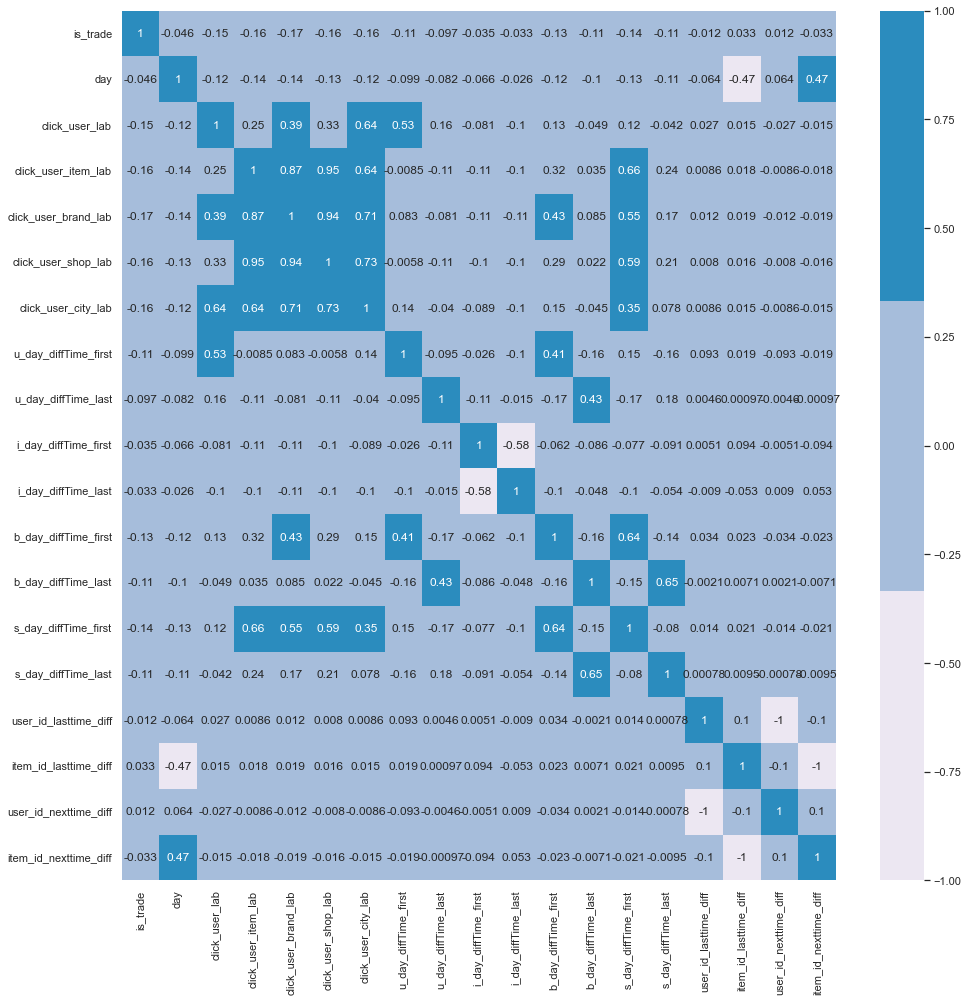

In [44]:
import brewer2mpl
#调颜色
bmap = brewer2mpl.get_map('PuBu', 'Sequential', 3)
colors = bmap.mpl_colors
def show_corr(clean_data_set):
    corr_data_matrix = clean_data_set.corr()
    corr_data_matrix['is_trade'].sort_values(ascending=False)
    #查看哪些字段与汽油车保值率最相关，我们先计算相关性矩阵
    df_tep1=corr_data_matrix.drop(columns='instance_id')
    sns.set(rc={"figure.figsize":(16, 16)})
    sns.heatmap(df_tep1.corr(), annot = True,cmap=colors)

show_corr(data_heatmap)

几个比较有分析价值的特征：'click_user_item_lab', 'click_user_brand_lab', 'click_user_shop_lab', 'click_user_city_lab'一组，
's_day_diffTime_last','b_day_diffTime_last'一组

## 热力图

In [45]:
data_heatmap.columns

Index(['instance_id', 'is_trade', 'day', 'click_user_lab',
       'click_user_item_lab', 'click_user_brand_lab', 'click_user_shop_lab',
       'click_user_city_lab', 'u_day_diffTime_first', 'u_day_diffTime_last',
       'i_day_diffTime_first', 'i_day_diffTime_last', 'b_day_diffTime_first',
       'b_day_diffTime_last', 's_day_diffTime_first', 's_day_diffTime_last',
       'user_id_lasttime_diff', 'item_id_lasttime_diff',
       'user_id_nexttime_diff', 'item_id_nexttime_diff'],
      dtype='object')

In [46]:
def draw_heatmap(data,x,y,z):
    grouped_df = data.groupby([x,y])[z].aggregate("mean").reset_index()
    grouped_df = grouped_df.pivot(x,y, z)
    plt.figure(figsize=(8, 6))
    sns.heatmap(grouped_df, cmap="coolwarm")  
    title = "Conversion Rate of "+x+" Vs "+y
    plt.title(title)
    plt.show()

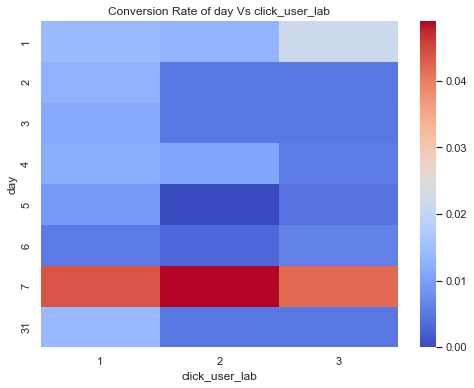

In [47]:
draw_heatmap(data,"day", "click_user_lab","is_trade")

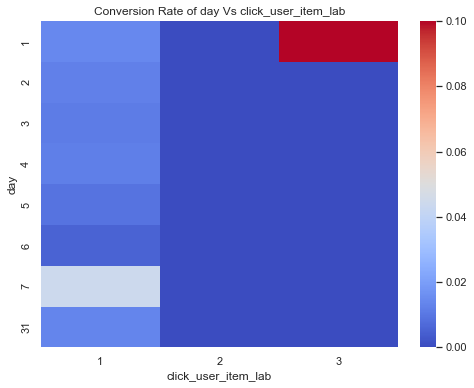

In [48]:
draw_heatmap(data_heatmap,"day", "click_user_item_lab","is_trade")

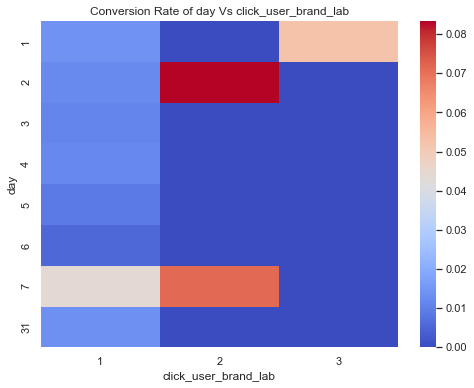

In [49]:
draw_heatmap(data_heatmap,"day", "click_user_brand_lab","is_trade")

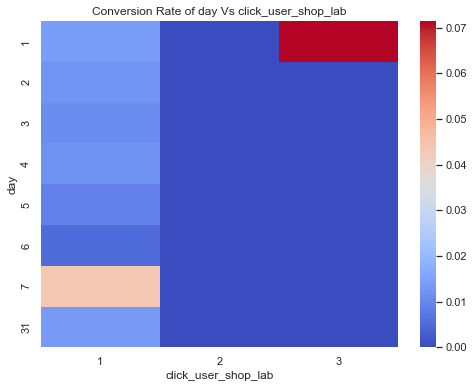

In [50]:
draw_heatmap(data_heatmap,"day", "click_user_shop_lab","is_trade")

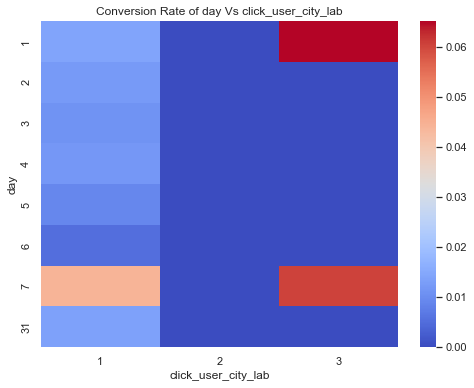

In [51]:
draw_heatmap(data_heatmap,"day", "click_user_city_lab","is_trade")

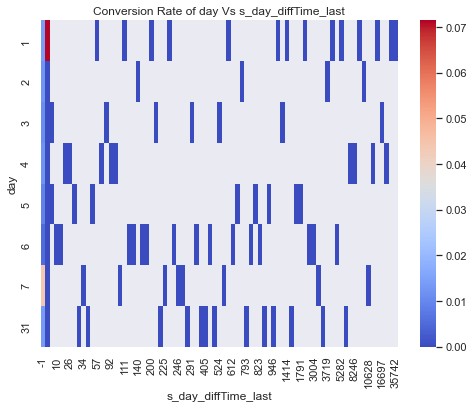

In [52]:
draw_heatmap(data_heatmap,"day", "s_day_diffTime_last","is_trade")

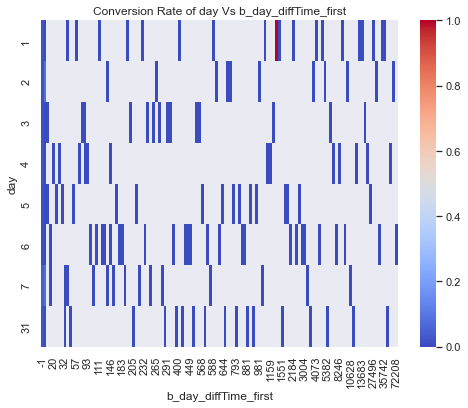

In [53]:
draw_heatmap(data_heatmap,"day", "b_day_diffTime_first","is_trade")

# 写文件

In [54]:
# 旧特征：cols，不包括instance_id', 'day'
# 得到新特征：
data = data.drop(cols, axis=1)
data.columns

Index(['instance_id', 'is_trade', 'day', 'click_user_lab',
       'click_user_item_lab', 'click_user_brand_lab', 'click_user_shop_lab',
       'click_user_city_lab', 'u_day_diffTime_first', 'u_day_diffTime_last',
       'i_day_diffTime_first', 'i_day_diffTime_last', 'b_day_diffTime_first',
       'b_day_diffTime_last', 's_day_diffTime_first', 's_day_diffTime_last',
       'user_id_lasttime_diff', 'item_id_lasttime_diff',
       'user_id_nexttime_diff', 'item_id_nexttime_diff'],
      dtype='object')

In [55]:
data.shape

(99085, 20)

In [56]:
## 得到全部训练集
print('经过处理后,全部训练集最终维度:', data.shape)
data.to_csv(path+'all_02.csv', index=False)

经过处理后,全部训练集最终维度: (99085, 20)


In [57]:
# 得到7号训练集
data = data.loc[data.day == 7]
data = data.drop('day', axis=1)
print('经过处理后,7号数据集最终维度:', data.shape)
print(data.columns.tolist())
data.to_csv(path+'day7_02.csv', index=False)

经过处理后,7号数据集最终维度: (10184, 19)
['instance_id', 'is_trade', 'click_user_lab', 'click_user_item_lab', 'click_user_brand_lab', 'click_user_shop_lab', 'click_user_city_lab', 'u_day_diffTime_first', 'u_day_diffTime_last', 'i_day_diffTime_first', 'i_day_diffTime_last', 'b_day_diffTime_first', 'b_day_diffTime_last', 's_day_diffTime_first', 's_day_diffTime_last', 'user_id_lasttime_diff', 'item_id_lasttime_diff', 'user_id_nexttime_diff', 'item_id_nexttime_diff']
